## Cleaning the data of code with TC and Topic

#### 1. importing the modeules required and making the dataframe

In [1]:
import numpy as np
import pandas as pd

In [2]:
df= pd.read_csv('python_data_all.csv', dtype=str, usecols=["code\n", "complexity", "tags"])

In [3]:
df.shape

(4917, 3)

In [4]:
df.head()

,code\n,complexity,tags
0,"from math import sqrt\n\na, v = map(int, input...",constant,"implementation,math"
1,"from math import *\na, vm = map(int, input().s...",constant,"implementation,math"
2,"""""""\n#If FastIO not needed, use this and don't...",constant,"implementation,math"
3,"from math import *\na, vm = map(int, input().s...",constant,"implementation,math"
4,"from math import *\na,v=list(map(int,input().s...",constant,"implementation,math"


In [5]:
df.tail()

,code\n,complexity,tags
4912,"import sys\ninput = sys.stdin.readline\n\nn, k...",np,"binary search,bitmasks,brute force,dp,strings,..."
4913,"import sys;input = sys.stdin.readline;n, k = m...",np,"binary search,bitmasks,brute force,dp,strings,..."
4914,import sys\n\n# sys.setrecursionlimit(200005)\...,np,"binary search,bitmasks,brute force,dp,strings,..."
4915,"import sys;input = sys.stdin.readline;n, k = m...",np,"binary search,bitmasks,brute force,dp,strings,..."
4916,"N, K = list(map(int, input().split()))\nS = in...",np,"binary search,bitmasks,brute force,dp,strings,..."


#### 2. Rename the column 'code\n' to 'code'

In [6]:
df.rename(columns= {'code\n' : 'code'}, inplace= True)
df.head()

,code,complexity,tags
0,"from math import sqrt\n\na, v = map(int, input...",constant,"implementation,math"
1,"from math import *\na, vm = map(int, input().s...",constant,"implementation,math"
2,"""""""\n#If FastIO not needed, use this and don't...",constant,"implementation,math"
3,"from math import *\na, vm = map(int, input().s...",constant,"implementation,math"
4,"from math import *\na,v=list(map(int,input().s...",constant,"implementation,math"


#### 3. Removing the NaN

In [7]:
df= df.dropna()
df.shape

(4901, 3)

#### 4. Delete duplicate rows having same code

In [8]:
df = df.drop_duplicates(subset=["code"], keep="first")
df.shape

(4702, 3)

#### 5. Complexity distribution

In [9]:
import matplotlib.pyplot as plt

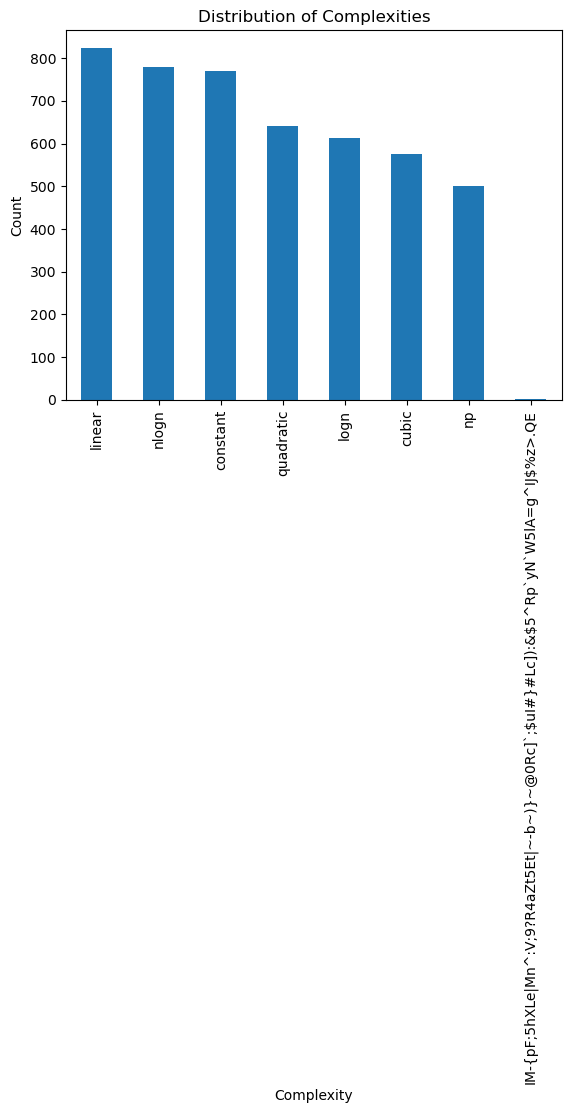

In [10]:
df["complexity"].value_counts().plot(kind="bar")
plt.title("Distribution of Complexities")
plt.xlabel("Complexity")
plt.ylabel("Count")
plt.show()


#### 5.1. Removing the anomaly from x-axis (Normalized)

In [11]:
valid_complexities = {"constant", "linear", "logarithmic", "quadratic", "cubic", "exponential", "np"}
df = df[df["complexity"].isin(valid_complexities)]

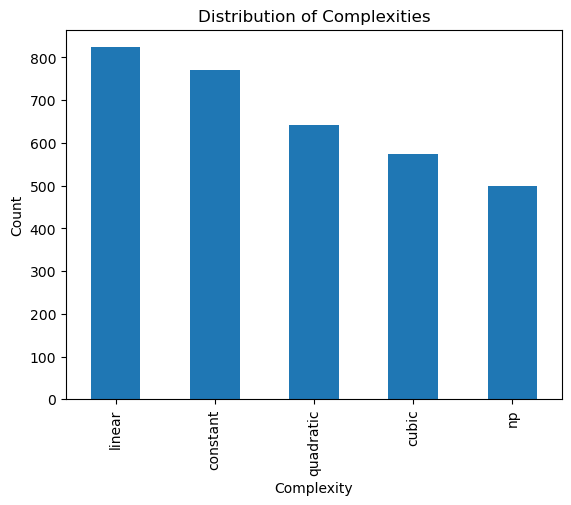

In [12]:
df["complexity"].value_counts().plot(kind="bar")
plt.title("Distribution of Complexities")
plt.xlabel("Complexity")
plt.ylabel("Count")
plt.show()

#### 6. Tags frequency (top 15 tags)

In [13]:
from collections import Counter

In [14]:
# flatten tags into a list (seperated them)
tags = df["tags"].dropna().str.split(",")
flat_tags = [tag.strip() for sublist in tags for tag in sublist]

In [15]:
# convert to Series
tag_series = pd.Series(flat_tags)

In [16]:
tag_counts = tag_series.value_counts().sort_values(ascending=False)
tag_counts.head(15)

implementation             1181
dp                         1128
math                       1020
greedy                      879
brute force                 677
bitmasks                    550
constructive algorithms     322
graphs                      308
number theory               248
sortings                    241
binary search               210
combinatorics               190
strings                     174
shortest paths              150
dfs and similar             139
Name: count, dtype: int64

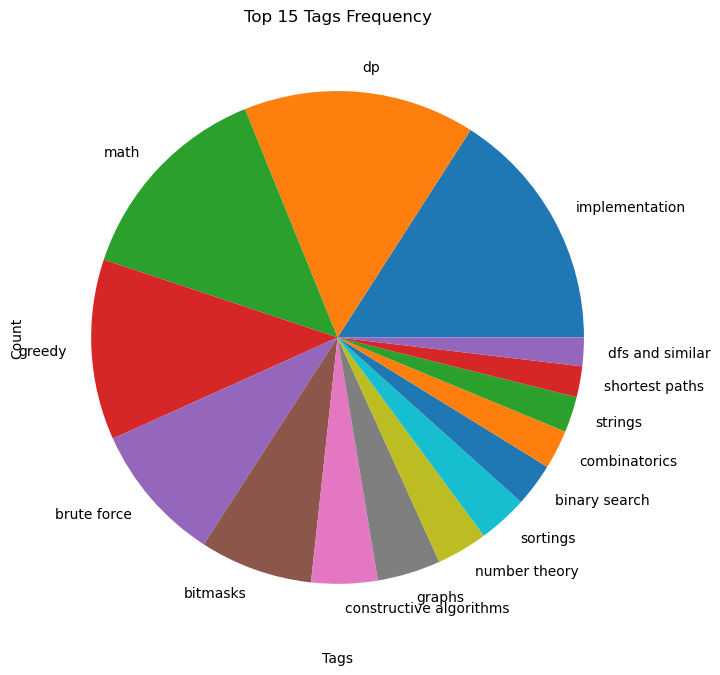

In [17]:
pd.Series(tag_counts).head(15).plot(kind="pie", figsize=(9,8))
plt.title("Top 15 Tags Frequency")
plt.xlabel("Tags")
plt.ylabel("Count")
plt.show()

#### 7. Complexity vs Tags

In [18]:
import seaborn as sns

In [19]:
tag_df = df.assign(tag=df["tags"].str.split(",")).explode("tag")
pivot = tag_df.pivot_table(index="complexity", columns="tag", aggfunc="size", fill_value=0)

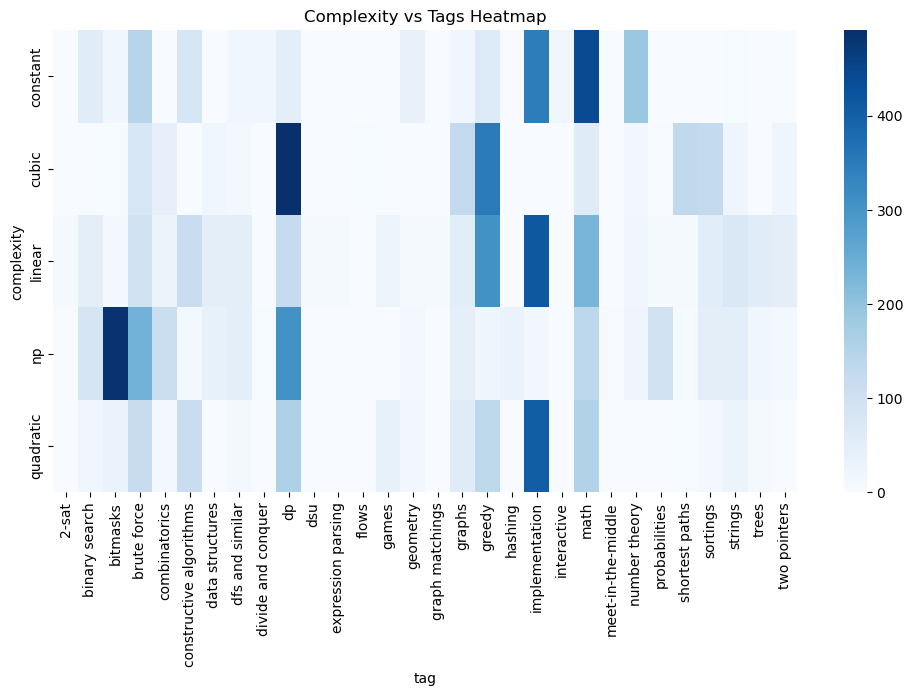

In [20]:
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="Blues", annot=False)
plt.title("Complexity vs Tags Heatmap")
plt.show()

#### 8. Outlier Check

In [21]:
df["code_length"] = df["code"].str.len()
df["code_length"].describe()

count     3310.000000
mean       973.172508
std       1786.349083
min          9.000000
25%        259.000000
50%        532.000000
75%       1008.500000
max      23167.000000
Name: code_length, dtype: float64

In [22]:
df.shape

(3310, 4)

### We need to remove the outliers as we can see some code of length around 23k

In [30]:
def clean_code(code):
    if not isinstance(code, str):
        return ""
    # Remove extra spaces and newlines
    code = code.strip()
    # remove comments
    code = re.sub(r'#.*', '', code)
    code = re.sub(r'""".*?"""', '', code, flags=re.DOTALL)
    code = re.sub(r"'''.*?'''", '', code, flags=re.DOTALL)
    # Replace multiple spaces/newlines with single space
    code = re.sub(r'\s+', ' ', code)
    return code

df['code'] = df['code'].apply(clean_code)

In [31]:
df.head()

,code,complexity,tags,code_length
0,"from math import sqrt a, v = map(int, input()....",constant,"implementation,math",509
1,"from math import * a, vm = map(int, input().sp...",constant,"implementation,math",614
2,"import os import sys from io import BytesIO, I...",constant,"implementation,math",2000
3,"from math import * a, vm = map(int, input().sp...",constant,"implementation,math",614
4,"from math import * a,v=list(map(int,input().sp...",constant,"implementation,math",432


#### 9. Filter short and extremely long snippets

In [32]:
df['code_length'] = df['code'].apply(len)

# Remove extremely short (<10 chars)
df = df[df['code_length'] >= 10]

# Truncate extremely long codes (>2000 chars)
max_len = 2000
df['code'] = df['code'].apply(lambda x: x[:max_len])
df['code_length'] = df['code'].apply(len)

In [33]:
df.shape

(3309, 4)

#### 10. Clean topics column

In [39]:
def clean_topics(topic_str):
    if isinstance(topic_str, str):
        # split by comma and remove extra spaces
        return [t.strip().lower() for t in topic_str.split(',') if t.strip()]
    elif isinstance(topic_str, list):
        return [t.strip().lower() for t in topic_str if t.strip()]
    else:
        return []

df['tags'] = df['tags'].apply(clean_topics)

In [41]:
print(df.head())

                                                code complexity  \
0  from math import sqrt a, v = map(int, input()....   constant   
1  from math import * a, vm = map(int, input().sp...   constant   
2  import os import sys from io import BytesIO, I...   constant   
3  from math import * a, vm = map(int, input().sp...   constant   
4  from math import * a,v=list(map(int,input().sp...   constant   

                     tags  code_length  
0  [implementation, math]          509  
1  [implementation, math]          614  
2  [implementation, math]         1999  
3  [implementation, math]          614  
4  [implementation, math]          432  


In [42]:
print("Code length stats:\n", df['code_length'].describe())

Code length stats:
 count    3309.000000
mean      583.329405
std       523.194199
min        11.000000
25%       218.000000
50%       407.000000
75%       747.000000
max      2000.000000
Name: code_length, dtype: float64


In [43]:
df.to_csv("cleaned_code_dataset.csv", index=False)